# Map plot examples

LADiM may output geographical coordinates, longitude and latitude. 
These variables is not part of the output in this example.
Instead the ROMS fields `lon_rho` and `lat_rho` can be used to compute
these coordinates in postprocessing.

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import shapely.wkb as wkb
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from postladim import ParticleFile

### Settings

In [2]:
# Files
particle_file = "out.nc"
grid_file = "../data/ocean_avg_0014.nc"

# Time step
t = 48    # 6 days (3 hours between output)

### Particle data to longitude and latitude

As longitude and latitude is not containes in the particle file
it has to be converted from the X and Y coordinates.
This can be done in several ways.
It can be calculated directly if the map projection of the grid is explicitly known.
Or the `xy2ll` method of the ladim2 Grid class.
Since the grid file has the lon and lat fields it can be done by bilinear 
interpolation, available as the `interp` method in `xarray`.

In [3]:
# Read the particle file

with ParticleFile(particle_file) as pf:
    X, Y = pf.position(t)

In [4]:
# Read the grid file

grid = xr.load_dataset(grid_file)

In [5]:
# Use interp in xarray for the interpolation

Lon = grid.lon_rho.interp(xi_rho=X, eta_rho=Y)
Lat = grid.lat_rho.interp(xi_rho=X, eta_rho=Y)

### Coast file

A coast file should be available in the latlon example.
If it is not available, run `python makecoast.py` in that directory to create the file.

In [6]:
# Read the coast file

coast_file = "../latlon/coast.wkb"
with open(coast_file, mode="rb") as fid:
    mpoly = wkb.load(fid)

Without mapping software, the data can be plotted in lon–lat space. 
This is the PlateCarree projection in Cartopy terminology

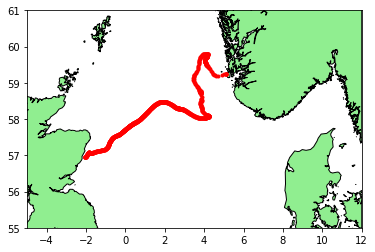

In [7]:
# Plot land
for p in mpoly:
    v = p.boundary.coords.xy
    plt.fill(*v, color='LightGreen', edgecolor='black')

# Plot the particle distribution 
plt.plot(Lon, Lat, 'r.')

# Limit the map extent
plt.axis((-5, 12, 55, 61));

### Use cartopy for real map projections

Use cartopy to provide the plot in Mercator projection to ensure orthogonality. 
For an one-off plot, land feature can be added by:
```python
   ax.add_feature(cfeature.GSHHSFeature(scale="i"))
```
For more plots from the same (or similar) domain, precomputing a coast line for 
the modell domain saves a lot of time.

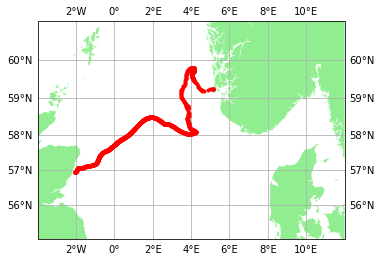

In [8]:
# Mercator projection

# Geographical extent
lon0, lon1, lat0, lat1 = -4, 12, 55, 61

# Projections
lonlat = ccrs.PlateCarree()
proj = ccrs.Mercator()
ax = plt.axes(projection=proj)
ax.set_extent([lon0, lon1, lat0, lat1], lonlat)

# Add land feature
coast = cfeature.ShapelyFeature(mpoly, crs=lonlat, facecolor="LightGreen")
ax.add_feature(coast)

# Add graticule
ax.gridlines(xlocs=range(lon0, lon1 + 2, 2), ylocs=range(lat0, lat1 + 1), 
             draw_labels=True)

# Plot the particles
ax.plot(Lon, Lat, ".", color="red", transform=lonlat);

#### Polar Stereographic

Also added bottom topography from the ocean model

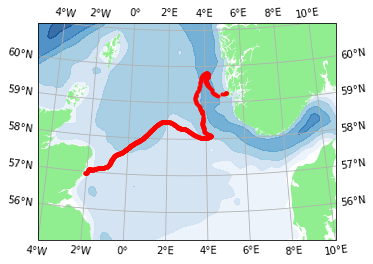

In [9]:
# Geographical extent
lon0, lon1, lat0, lat1 = -4, 10, 55, 61

# Projections
lonlat = ccrs.PlateCarree()
proj = ccrs.NorthPolarStereo(central_longitude=0.5*(lon0 + lon1))
ax = plt.axes(projection=proj)
ax.set_extent([lon0, lon1, lat0, lat1], lonlat)

# Add land feature
coast = cfeature.ShapelyFeature(mpoly, crs=lonlat, facecolor="LightGreen")
ax.add_feature(coast)

# Add bottom topography
levels = [25, 50, 100, 250, 500, 1000, 2500]
plt.contourf(grid.lon_rho, grid.lat_rho, np.log(grid.h),
             levels=np.log(levels), cmap='Blues', alpha=0.8, transform=lonlat)


# Add graticule
ax.gridlines(xlocs=range(lon0, lon1 + 2, 2), ylocs=range(lat0, lat1 + 1), 
             draw_labels=True, y_inline=False)

# Plot the particles
ax.plot(Lon, Lat, ".", color="red", transform=lonlat);

#### Wedge-shaped Polar Stereographic

It is possible to use non-rectangular boundary for the map.

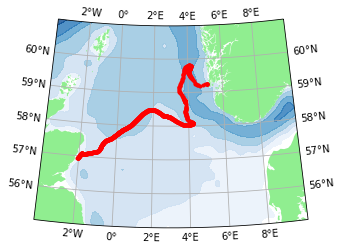

In [10]:

# Geographical extent
lon0, lon1, lat0, lat1 = -4, 10, 55, 61

# Projections
lonlat = ccrs.PlateCarree()
proj = ccrs.NorthPolarStereo(central_longitude=0.5*(lon0 + lon1))
ax = plt.axes(projection=proj)
# Go slightly south of lat0 to make room for curved botto,
ax.set_extent([lon0, lon1, lat0-0.5, lat1], lonlat)

# Set up a wedge-shaped boundary
res = 20
south = proj.transform_points(
    lonlat, np.linspace(lon0, lon1, res), np.array(res * [lat0])
)
north = proj.transform_points(
    lonlat, np.linspace(lon1, lon0, res), np.array(res * [lat1])
)
boundary = np.vstack((north[:, :2], south[:, :2]))
ax.set_boundary(mpath.Path(boundary), transform=proj)

# Add land feature
coast = cfeature.ShapelyFeature(mpoly, crs=lonlat, facecolor="LightGreen")
ax.add_feature(coast)

# Add bottom topography
levels = [25, 50, 100, 250, 500, 1000, 2500]
plt.contourf(grid.lon_rho, grid.lat_rho, np.log(grid.h),
             levels=np.log(levels), cmap='Blues', alpha=0.8, transform=lonlat)

# Add graticule
ax.gridlines(xlocs=range(lon0, lon1 + 2, 2), ylocs=range(lat0, lat1 + 1), 
             draw_labels=True, y_inline=False)

# Plot the particles
ax.plot(Lon, Lat, ".", color="red", transform=lonlat);

### Map tiles as background


Use map tiles from [Open Street Map](https://openstreetmap.org) (OSM) or [Stamen](https://maps.stamen.com).


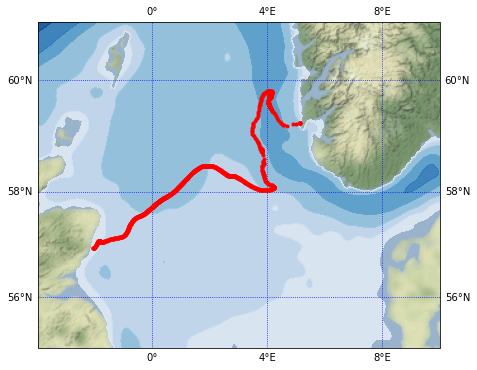

In [15]:
# Need cartopy images tiles support
import cartopy.io.img_tiles as cimgt

# Choose Stamen og Open Street Map
background = cimgt.Stamen('terrain-background')
# background = cimgt.OSM()

# Make the figure larger
plt.figure(figsize=(8, 6))

# Use the tile's projection.
ax = plt.axes(projection=background.crs)

# Map extent
ax.set_extent([lon0, lon1, lat0, lat1])

# Map background, zoom level 5
ax.add_image(background, 5)

# Add bottom topography
levels = [25, 50, 100, 250, 500, 1000, 2500]
plt.contourf(grid.lon_rho, grid.lat_rho, np.log(grid.h),
             levels=np.log(levels), cmap='Blues', alpha=0.8, 
             transform=ccrs.PlateCarree())

# Add grid lines
ax.gridlines(xlocs=[0, 4, 8], ylocs=[56, 58, 60], 
             draw_labels=True, linestyle=":", color="blue")

# Plot the particles
plt.plot(Lon, Lat,'r.', transform=ccrs.Geodetic());
